In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# from os import path

# # nazwa archiwum do dostosowania
# !unzip '/content/drive/MyDrive/archive.zip'

In [1]:
# !pip install ydata_profiling
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import cv2
import numpy as np
import keras
import tensorflow as tf
import numpy as np
import imgaug.augmenters as iaa

In [2]:
class Dataset:
    def __init__(self,
                 list_attr_celeba_path="list_attr_celeba.csv",
                 list_bbox_celeba_path="list_bbox_celeba.csv",
                 list_eval_partition_path="list_eval_partition.csv",
                 list_landmarks_align_celeba_path="list_landmarks_align_celeba.csv",
                 images_path="img_align_celeba/img_align_celeba/"
                 ):

        # uncomment
        list_attr_celeba = pd.read_csv(list_attr_celeba_path)
        list_bbox_celeba = pd.read_csv(list_bbox_celeba_path)
        list_eval_partition = pd.read_csv(list_eval_partition_path)
        list_landmarks_align_celeba = pd.read_csv(list_landmarks_align_celeba_path)

        df = list_attr_celeba.merge(list_bbox_celeba, on='image_id')
        df = df.merge(list_bbox_celeba, on='image_id')
        df = df.merge(list_eval_partition, on='image_id')
        self.df = df.merge(list_landmarks_align_celeba, on='image_id')
        self.images_path = images_path

    def generate_report(self, report_name='your_report'):
        profile = ProfileReport(self.df, title="Pandas Profiling Report")
        profile.to_file(f"{report_name}.html")

    def show_some_examples(self, attribute: str, positive: bool = True):
        """
        Quick visualization of some examples

        :param attribute: One of boolean attribute:
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
        'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows','Chubby', 'Double_Chin', 'Eyeglasses',
        'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
        'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
        'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
        'Wearing_Necklace', 'Wearing_Necktie', 'Young'
        :type attribute: str
        :param positive: show positive examples or not (negative if false)
        :type positive: boolean
        :return: None
        :rtype: None
        """
        print(self.df.columns)
        if positive:
            exist = 1
        else:
            exist = -1

        df = self.df[self.df[attribute] == exist]
        images = list(df.head(9)['image_id'])
        images = [cv2.imread(self.images_path+path) for path in images]
        horizontal_1 = np.concatenate((images[0], images[1], images[2]), axis=1)
        horizontal_2 = np.concatenate((images[3], images[4], images[5]), axis=1)
        horizontal_3 = np.concatenate((images[6], images[7], images[8]), axis=1)
        vertical = np.concatenate((horizontal_1, horizontal_2, horizontal_3), axis=0)
        # plot first few images
        # define subplot
        plt.subplot(330 + 1 + 0)
        # plot raw pixel data
        plt.imshow(vertical)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, images, labels, batch_size=8, shuffle=False, augment=False):
        self.labels = labels  # array of labels
        self.images = images  # array of images
        self.batch_size = batch_size  # batch size
        self.shuffle = shuffle  # shuffle bool
        self.augment = augment  # augment data bool
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # select data and load images
        labels = np.array([self.labels[k] for k in indexes])
        images = np.array([self.images[k] for k in indexes])

        # preprocess and augment data
        if self.augment:
            images = self.augmentor(images)

        images = images / 255
        return images, labels

    @staticmethod
    def augmentor(images):
        """Apply data augmentation"""
        def sometimes(aug):
            return iaa.Sometimes(0.5, aug)
        list_of_aumgenters = []
        list_of_aumgenters.extend([sometimes(iaa.Crop(px=(1, 16), keep_size=True)),
                                   sometimes(iaa.Fliplr(0.5)),
                                   sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))])

        seq = iaa.Sequential(list_of_aumgenters)

        return seq.augment_images(images)

In [3]:
classification_dataset = Dataset() #definicja klasy Dataset

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'x_1_x', 'y_1_x', 'width_x', 'height_x',
       'x_1_y', 'y_1_y', 'width_y', 'height_y', 'partition', 'lefteye_x',
       'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y',
       'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y'],
      dtype='object')


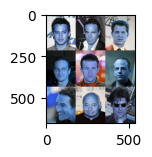

In [4]:
classification_dataset.show_some_examples('5_o_Clock_Shadow') #Podgląd kilku obrazów z tym samym atrybutem

In [5]:
print('Just for test')

Just for test
